# Summarise audience motion per section of concert
Plot and describe how the audience moved to the music as it was performed. More or less, shifting together or not

Look at how pairs of participants share movemement, in hall

First load audience motion data (summary QoM), proximity info, concert timing info and then calculate correlations per pair and condition. 

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import pingouin as pg

In [16]:
# import activity analysis functions from aa.py file in the same folder as this jupiter notebook
%load_ext autoreload
%autoreload 1
%aimport aa

In [17]:
%reload_ext autoreload

In [2]:
# NEW NO PD APPEND
def gap_nans(data,gap_t):
    # data is a pandas dataframe with columns called time and/or time_concert which is used to ID gaps greater than gap_T
    # gap_T is in milliseconds (ms)
    # rows of NaN data is added to non-time columns before the first sample, at edges of each gap, and after the last sample of data
    # these nans prevent interpolation errors through missing data
    cols = data.columns
    if 'time' in cols:
        time_col = 'time'
    if 'time_concert' in cols:
        time_col = 'time_concert'
        
    deltat = round(0.35*data[time_col].diff().median())
    dtdeltat =  pd.to_timedelta(deltat,unit = 'ms')
    dt = data[time_col].diff()    
    gapsi = np.array(dt[dt>gap_t].index)
    a = np.append(gapsi-1,dt.index[-1])
    gapsd = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsd[c] = data.loc[a,c]+dtdeltat
        if c.startswith('time'):
            gapsd[c] = data.loc[a,c]+deltat 

    a = np.append(gapsi,dt.index[0])
    gapsp = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsp[c] = data.loc[a,c]-dtdeltat
        if c.startswith('time'):
            gapsp[c] = data.loc[a,c]-deltat 

    data = pd.concat([gapsp,gapsd,data]).sort_values(time_col,ignore_index=True)
    return data

In [3]:
general_loc = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/'

public_mlmotion = general_loc + 'Public/Motion_ML/'
public_ax3 = general_loc +  'Public/Motion_AX3/'
public_Part = general_loc + 'Public/Participants/'
public_time = general_loc + 'Public/Timing/'

In [12]:
concert_times = pd.read_csv(public_time +'Events_Main.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format

concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('Datetime')

In [57]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)

# concert times 10 Hz
ts_ct = np.arange(-1086,9715, 0.1)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')


concert_times = pd.read_csv(public_time +'Events_Full.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format
concert_times['sequence'] = concert_times.index
concert_times.set_index('Datetime',inplace = True)
concert_times.iloc[:5]

,Time_s,Time_ms,Event,Event_Type,Time_Stream,sequence
Datetime,,,,,,
2021-10-26 17:36:35,-691.24,-691240,Clapping,Audience Action,946.00,0
2021-10-26 17:36:52,-674.12,-674120,Clapping Off,Audience Action,963.12,1
2021-10-26 17:36:53,-673.12,-673120,Danish,Speech,964.12,2
2021-10-26 17:37:10,-656.12,-656120,English,Speech,981.12,3
2021-10-26 17:37:20,-645.60,-645600,Danish,Speech,991.64,4


In [6]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'] == 'A',:] # in person hall participant
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
alignedParts

,Participant_Code,Participant_Number,Attendance,Questionnaire_Language,Motion_Quality,Link_Conflicts,Seat_Zone,Location,Longitude_Truncated,Lattitude_Truncated,Offset_1,Offset_2,Watch_Alone
0,ADQ001,1,A,D,Q,0,6.0,NaN,NaN,NaN,0.14,0.16,0.0
1,ADQ002,2,A,D,Q,0,3.0,NaN,NaN,NaN,NaN,-0.36,0.0
2,ADQ003,3,A,D,Q,0,2.0,NaN,NaN,NaN,0.88,1.02,0.0
3,ADQ004,4,A,D,Q,0,4.0,NaN,NaN,NaN,0.44,0.62,1.0
4,ADQ005,5,A,D,Q,0,4.0,NaN,NaN,NaN,0.04,0.12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,AEQ086,86,A,E,Q,0,5.0,NaN,NaN,NaN,NaN,0.34,0.0
81,AEQ087,87,A,E,Q,1,3.0,NaN,NaN,NaN,0.12,0.28,0.0
82,AEQ088,88,A,E,Q,0,2.0,NaN,NaN,NaN,0.10,0.06,0.0
83,AEQ089,89,A,E,Q,0,4.0,NaN,NaN,NaN,0.28,0.38,0.0


In [7]:
Main_concert_times[Main_concert_times['Event'].str.contains('Beethoven')]

,Time_s,Time_ms,Event,Event_Type,Time_Stream,Event_Duration,sequence
Datetime,,,,,,,
2021-10-26 17:49:03,57.40,57400,Beethoven 1,Music,1694.64,418.68,8
2021-10-26 17:56:02,476.08,476080,Beethoven 2,Music,2113.32,225.10,9
2021-10-26 17:59:47,701.18,701180,Beethoven 3,Music,2338.42,468.98,10
2021-10-26 18:07:36,1170.16,1170160,Beethoven 4,Music,2807.40,440.20,11
2021-10-26 18:14:56,1610.36,1610360,Clapping for Beethoven,Applause,3247.60,31.64,12
2021-10-26 18:15:48,1662.00,1662000,Survey for Beethoven,Survey,3299.24,330.94,14


In [9]:
tic = time.time()
# load those motion traces 
# gather the aligned recordings for the live performance. Combining AX3 and ML data!
aud_df = pd.DataFrame(index = ts_ct)
kept_dev = []
gap_t = 1000

for i,participant in alignedParts.iterrows():
    part = participant['Participant_Code']
    if part[2]=='Q': # Motionlab phone acc
        inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
    else: # AX3
        inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
    inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
    datas = gap_nans(inst_d,1000)
    #get concert time
    resampled = pd.DataFrame(index = ts_ct)
    cols = datas.columns
    for col in cols[1:]:
        f = interpolate.interp1d(datas['time'], datas[col],fill_value='extrapolate')
        resampled[col] = f(ts_ct)
        
    # extract 1D accelerometer feature for easy comparison
    # and basic normalisation
    b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
    
    if part[2]=='R': # aligned AX3 correction factor (basic but verified for low motion conditions)
        aud_df[part] = b*6 
    else:
        aud_df[part] = b
#     if np.nanmedian(b)>0:
#         aud_df[part] = b/np.nanmedian(b)
#     else:
#         aud_df[part] = b/np.nanmean(b)
        
aud_df.index = dt_ct
print(time.time()-tic)

110.70444011688232


## Beethoven

In [58]:
musics = 'Beethoven'
#seg_times = concert_times[concert_times['Event'].str.contains('Beethoven')]
seg_times = concert_times.iloc[50:68].copy()
#seg_times = concert_times[concert_times['Event'].str.contains('Bach')]
seg_times

,Time_s,Time_ms,Event,Event_Type,Time_Stream,sequence
Datetime,,,,,,
2021-10-26 17:48:46,40.36,40360,Clapping Off,Audience Action,1677.60,50
2021-10-26 17:48:57,50.76,50760,Quiet,Audience Action,1688.00,51
2021-10-26 17:49:03,57.40,57400,Beethoven 1,Music Performance,1694.64,52
2021-10-26 17:55:44,457.84,457840,Quiet,Audience Action,2095.08,53
2021-10-26 17:56:02,476.08,476080,Beethoven 2,Music Performance,2113.32,54
2021-10-26 17:59:19,672.98,672980,Quiet,Audience Action,2310.22,55
2021-10-26 17:59:47,701.18,701180,Beethoven 3,Music Performance,2338.42,56
2021-10-26 18:07:20,1154.28,1154280,Quiet,Audience Action,2791.52,57
2021-10-26 18:07:36,1170.16,1170160,Beethoven 4,Music Performance,2807.40,58


[Timestamp('2021-10-26 17:48:46'), Timestamp('2021-10-26 18:21:26')]


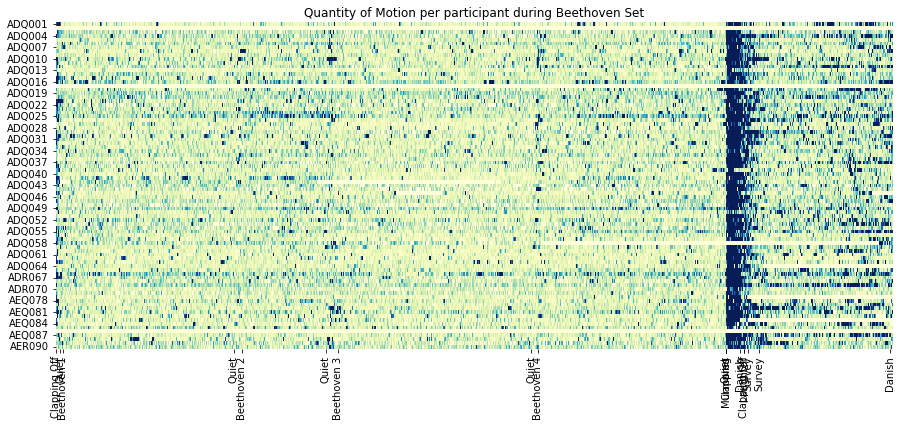

In [59]:
# now evaluate Beethove
seg_start = concert_times.iloc[50,:].name #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = concert_times.iloc[68,:].name
print([seg_start,seg_end])

seg_df = aud_df.loc[seg_start:seg_end]
#seg_df = seg_df.loc[:,seg_df.sum()>0]
seg_df = seg_df.fillna(0)

fig, (ax1) = plt.subplots(1, 1,figsize = [15,6])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=0.4,cbar=False, cmap="YlGnBu")

new_xticks = len(seg_df)*(seg_times['Time_s'] - seg_times['Time_s'][0])/(seg_end.timestamp()-seg_start.timestamp())
# plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
ax1.set_xticks(new_xticks)
ax1.set_xticklabels(seg_times['Event'])
plt.title('Quantity of Motion per participant during ' + musics + ' Set')
plt.savefig('./Plots/qom_'+musics+'.png',dpi = 300)
plt.show()


In [60]:
Data = seg_df.copy()
Data.index = np.arange(0,len(seg_df))/10

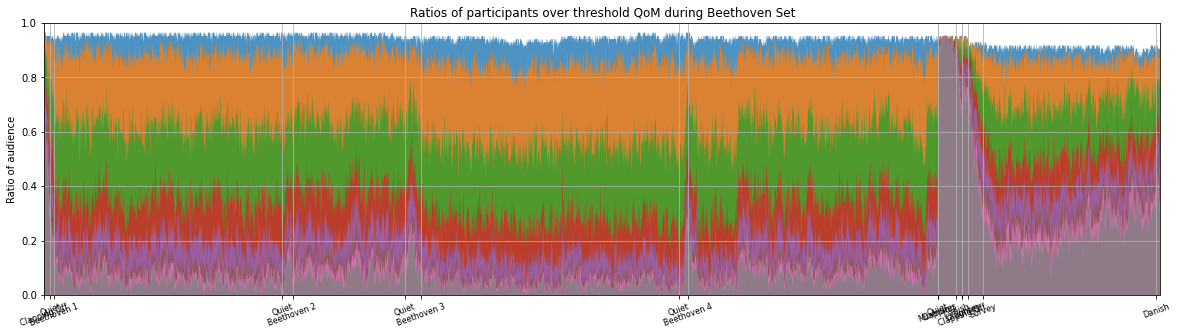

In [61]:
fig,ax = plt.subplots(1,1,figsize=[20,5] )
thresh = np.arange(0.04,0.32,0.04)
df_threshed = pd.DataFrame()
for th in thresh:
    df = aa.activityCount(Data,1,0.5,th,'UBound')
    df_threshed[str(th)]=df['Total']
    #df.plot(y = 'Total',ax=ax,label=str(th))
    x = df.index
    y1 = 0
    y2 = df.Total
    ax.fill_between(x,y1,y2,alpha = 0.8)
    
    
new_xticks = seg_times['Time_s'] - seg_times['Time_s'][0]
plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
plt.xlim([x[0]-1,x[-1]])
plt.ylim([0,1])
plt.ylabel('Ratio of audience')
plt.grid() 
plt.title('Ratios of participants over threshold QoM during ' + musics + ' Set')
plt.savefig('./Plots/ubound__'+musics+'.png',dpi = 300)
plt.show()

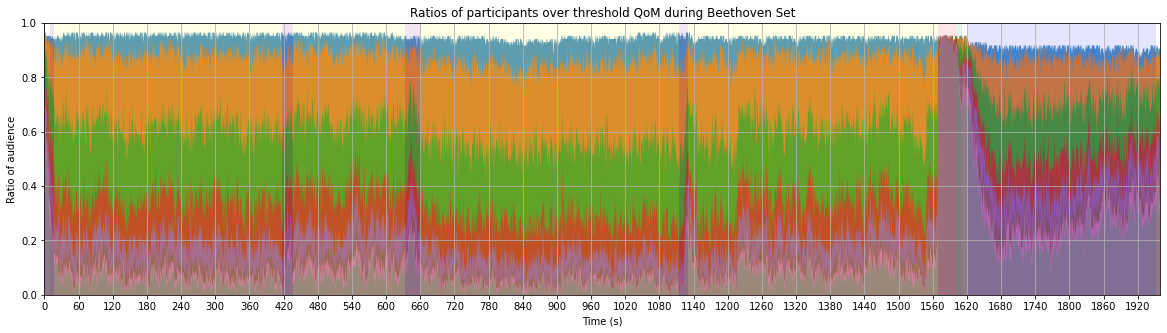

In [62]:
fig,ax = plt.subplots(1,1,figsize=[20,5] )

thresh = np.arange(0.04,0.32,0.04)
df_threshed = pd.DataFrame()
for th in thresh:
    df = aa.activityCount(Data,1,0.5,th,'UBound')
    df_threshed[str(th)]=df['Total']
    #df.plot(y = 'Total',ax=ax,label=str(th))
    x = df.index
    y1 = 0
    y2 = df.Total
    ax.fill_between(x,y1,y2,alpha = 0.8)

seg_times.loc[:,'Time_s'] = seg_times.loc[:,'Time_s'] - seg_times.iloc[0,0]

yrange = [0,2.0]
for i in range(len(seg_times)-1):
    r= seg_times.iloc[i,:]
    ei = seg_times.Time_s[i]
    ej = seg_times.Time_s[i+1]
    if r['Event'].endswith('Clapping'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='red', alpha=0.1)
    if r['Event'].startswith('Beethoven'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='yellow', alpha=0.1)
    if r['Event_Type'].endswith('Speech'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='green', alpha=0.1)
    if r['Event'].startswith('Survey'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='blue', alpha=0.1)
    if r['Event'].startswith('Quiet'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='purple', alpha=0.1)

# new_xticks = seg_times['Time_s'] - seg_times['Time_s'][0]
#plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
plt.xticks(np.arange(seg_times.Time_s[0],seg_times.Time_s[-1],60))
plt.xlim([x[0]-1,x[-1]])
plt.ylim([0,1])
plt.ylabel('Ratio of audience')
plt.grid() 
plt.title('Ratios of participants over threshold QoM during ' + musics + ' Set')
plt.xlabel('Time (s)')

plt.savefig('./Plots/ubound__'+musics+'.png',dpi = 300)
plt.show()

In [34]:
x

Float64Index([   0.5,    1.0,    1.5,    2.0,    2.5,    3.0,    3.5,    4.0,
                 4.5,    5.0,
              ...
              1955.0, 1955.5, 1956.0, 1956.5, 1957.0, 1957.5, 1958.0, 1958.5,
              1959.0, 1959.5],
             dtype='float64', name='Time', length=3919)

## Schnittke

[Timestamp('2021-10-26 18:21:42'), Timestamp('2021-10-26 18:46:50')]


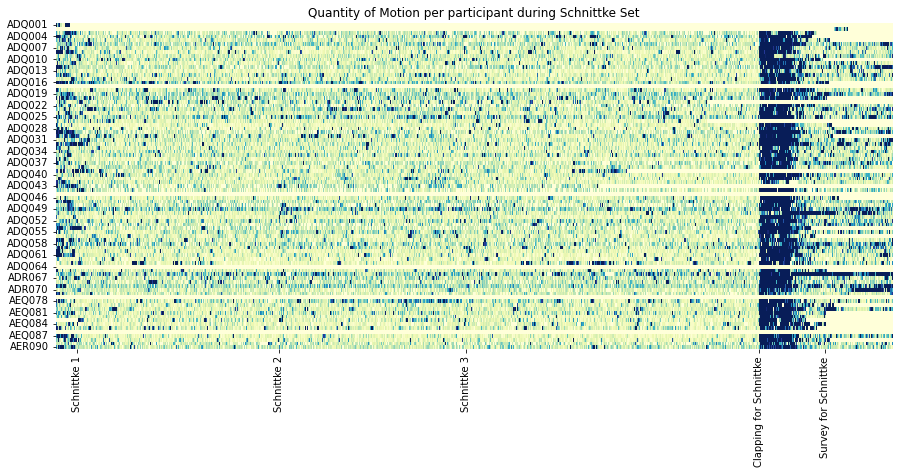

In [64]:
# now evaluate Shnittke
# concert_times.iloc[70:90]
seg_start = concert_times.iloc[70,:].name #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = concert_times.iloc[89,:].name
seg_times = Main_concert_times[Main_concert_times['Event'].str.contains('Schnitt')]
print([seg_start,seg_end])

seg_df = aud_df.loc[seg_start:seg_end]
#seg_df = seg_df.loc[:,seg_df.sum()>0]
seg_df = seg_df.fillna(0)

fig, (ax1) = plt.subplots(1, 1,figsize = [15,6])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=0.4,cbar=False, cmap="YlGnBu")

new_xticks = len(seg_df)*(seg_times['Time_s'] - concert_times.iloc[70,:].Time_s)/(seg_end.timestamp()-seg_start.timestamp())
# plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
ax1.set_xticks(new_xticks)
ax1.set_xticklabels(seg_times['Event'])
plt.title('Quantity of Motion per participant during ' + musics + ' Set')
plt.savefig('./Plots/qom_'+musics+'.png',dpi = 300)
plt.show()


In [74]:
musics = 'Schnittke'
seg_times = concert_times.iloc[70:90].copy()

#seg_times = concert_times[concert_times['Event'].str.contains('Bach')]
seg_times

,Time_s,Time_ms,Event,Event_Type,Time_Stream,sequence
Datetime,,,,,,
2021-10-26 18:21:42,2016.12,2016120,Clapping Off,Audience Action,3653.36,70
2021-10-26 18:22:17,2050.50,2050500,Quiet,Audience Action,3687.74,71
2021-10-26 18:22:20,2054.48,2054480,Schnittke 1,Music Performance,3691.72,72
2021-10-26 18:28:14,2408.48,2408480,Quiet,Audience Action,4045.72,73
2021-10-26 18:28:25,2418.76,2418760,Schnittke 2,Music Performance,4056.00,74
2021-10-26 18:33:55,2749.16,2749160,Quiet,Audience Action,4386.40,75
2021-10-26 18:34:01,2755.28,2755280,Schnittke 3,Music Performance,4392.52,76
2021-10-26 18:37:11,2945.44,2945440,Passing Siren,Intrusion,4582.68,77
2021-10-26 18:37:14,2948.08,2948080,Murmures,Audience Action,4585.32,78


In [75]:
seg_times.loc[:,'Time_s'] = seg_times.loc[:,'Time_s'].values - seg_times.iloc[0,0]
# seg_times.drop() intrusion and murumurs 

,Time_s,Time_ms,Event,Event_Type,Time_Stream,sequence
Datetime,,,,,,
2021-10-26 18:21:42,0.00,2016120,Clapping Off,Audience Action,3653.36,70
2021-10-26 18:22:17,34.38,2050500,Quiet,Audience Action,3687.74,71
2021-10-26 18:22:20,38.36,2054480,Schnittke 1,Music Performance,3691.72,72
2021-10-26 18:28:14,392.36,2408480,Quiet,Audience Action,4045.72,73
2021-10-26 18:28:25,402.64,2418760,Schnittke 2,Music Performance,4056.00,74
2021-10-26 18:33:55,733.04,2749160,Quiet,Audience Action,4386.40,75
2021-10-26 18:34:01,739.16,2755280,Schnittke 3,Music Performance,4392.52,76
2021-10-26 18:37:11,929.32,2945440,Passing Siren,Intrusion,4582.68,77
2021-10-26 18:37:14,931.96,2948080,Murmures,Audience Action,4585.32,78


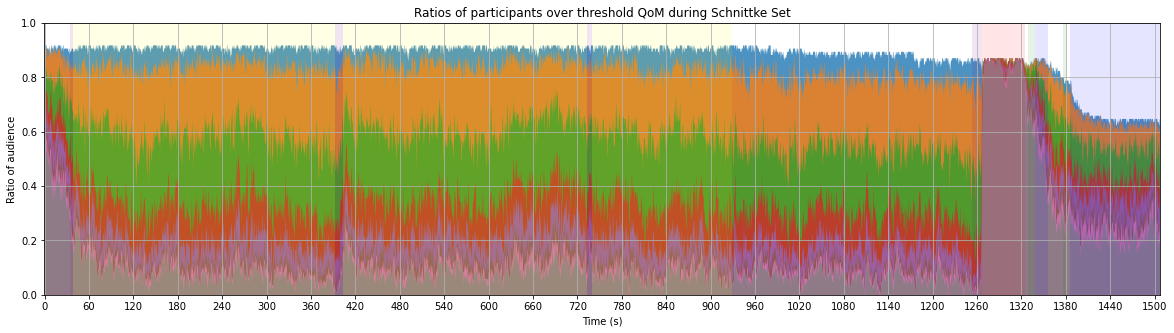

In [77]:
Data = seg_df.copy()
Data.index = np.arange(0,len(seg_df))/10

fig,ax = plt.subplots(1,1,figsize=[20,5] )

thresh = np.arange(0.04,0.32,0.04)
df_threshed = pd.DataFrame()
for th in thresh:
    df = aa.activityCount(Data,1,0.5,th,'UBound')
    df_threshed[str(th)]=df['Total']
    #df.plot(y = 'Total',ax=ax,label=str(th))
    x = df.index
    y1 = 0
    y2 = df.Total
    ax.fill_between(x,y1,y2,alpha = 0.8)


yrange = [0,2.0]
for i in range(len(seg_times)-1):
    r= seg_times.iloc[i,:]
    ei = seg_times.Time_s[i]
    ej = seg_times.Time_s[i+1]
    if r['Event'].endswith('Clapping'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='red', alpha=0.1)
    if r['Event'].startswith(musics):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='yellow', alpha=0.1)
    if r['Event_Type'].endswith('Speech'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='green', alpha=0.1)
    if r['Event'].startswith('Survey'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='blue', alpha=0.1)
    if r['Event'].startswith('Quiet'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='purple', alpha=0.1)

# new_xticks = seg_times['Time_s'] - seg_times['Time_s'][0]
#plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
plt.xticks(np.arange(seg_times.Time_s[0],seg_times.Time_s[-1],60))
plt.xlim([x[0]-1,x[-1]])
plt.ylim([0,1])
plt.ylabel('Ratio of audience')
plt.grid() 
plt.title('Ratios of participants over threshold QoM during ' + musics + ' Set')
plt.xlabel('Time (s)')

plt.savefig('./Plots/ubound__'+musics+'.png',dpi = 300)
plt.show()

## Bach

[Timestamp('2021-10-26 19:15:39'), Timestamp('2021-10-26 19:30:48')]


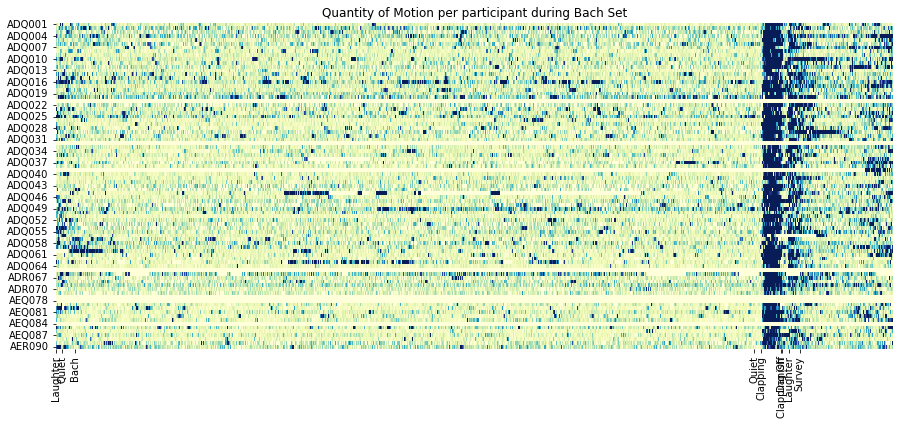

In [80]:

seg_start = concert_times.iloc[122,:].name #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = concert_times.iloc[131,:].name
#seg_times = Main_concert_times[Main_concert_times['Event'].str.contains('Schnitt')]
print([seg_start,seg_end])

seg_df = aud_df.loc[seg_start:seg_end]
#seg_df = seg_df.loc[:,seg_df.sum()>0]
seg_df = seg_df.fillna(0)

fig, (ax1) = plt.subplots(1, 1,figsize = [15,6])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=0.4,cbar=False, cmap="YlGnBu")

new_xticks = len(seg_df)*(seg_times['Time_s'] - seg_times['Time_s'][0])/(seg_end.timestamp()-seg_start.timestamp())
# plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
ax1.set_xticks(new_xticks)
ax1.set_xticklabels(seg_times['Event'])
plt.title('Quantity of Motion per participant during ' + musics + ' Set')
plt.savefig('./Plots/qom_'+musics+'.png',dpi = 300)
plt.show()

In [84]:
musics = 'Bach'
seg_times = concert_times.iloc[122:131].copy()
#seg_times = concert_times[concert_times['Event'].str.contains('Bach')]
seg_times.loc[:,'Time_s'] = seg_times.loc[:,'Time_s'].values - seg_times.iloc[0,0]

seg_times

,Time_s,Time_ms,Event,Event_Type,Time_Stream,sequence
Datetime,,,,,,
2021-10-26 19:15:39,0.00,5253240,Laughter,Audience Action,6890.48,122
2021-10-26 19:15:46,6.96,5260200,Quiet,Audience Action,6897.44,123
2021-10-26 19:16:00,21.12,5274360,Bach,Music Performance,6911.60,124
2021-10-26 19:28:18,758.56,6011800,Quiet,Audience Action,7649.04,125
2021-10-26 19:28:25,766.20,6019440,Clapping,Audience Action,7656.68,126
2021-10-26 19:28:47,787.84,6041080,Danish,Speech,7678.32,127
2021-10-26 19:28:48,788.54,6041780,Clapping Off,Audience Action,7679.02,128
2021-10-26 19:28:55,796.08,6049320,Laughter,Audience Action,7686.56,129
2021-10-26 19:29:07,808.10,6061340,Survey,Instructions,7698.58,130


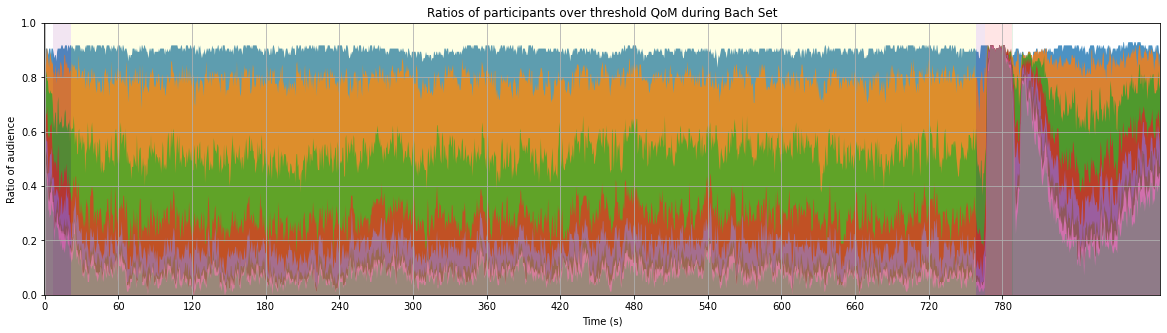

In [85]:
Data = seg_df.copy()
Data.index = np.arange(0,len(seg_df))/10

fig,ax = plt.subplots(1,1,figsize=[20,5] )

thresh = np.arange(0.04,0.32,0.04)
df_threshed = pd.DataFrame()
for th in thresh:
    df = aa.activityCount(Data,1,0.5,th,'UBound')
    df_threshed[str(th)]=df['Total']
    #df.plot(y = 'Total',ax=ax,label=str(th))
    x = df.index
    y1 = 0
    y2 = df.Total
    ax.fill_between(x,y1,y2,alpha = 0.8)


yrange = [0,2.0]
for i in range(len(seg_times)-1):
    r= seg_times.iloc[i,:]
    ei = seg_times.Time_s[i]
    ej = seg_times.Time_s[i+1]
    if r['Event'].endswith('Clapping'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='red', alpha=0.1)
    if r['Event'].startswith(musics):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='yellow', alpha=0.1)
    if r['Event_Type'].endswith('Speech'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='green', alpha=0.1)
    if r['Event'].startswith('Survey'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='blue', alpha=0.1)
    if r['Event'].startswith('Quiet'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='purple', alpha=0.1)

# new_xticks = seg_times['Time_s'] - seg_times['Time_s'][0]
#plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
plt.xticks(np.arange(seg_times.Time_s[0],seg_times.Time_s[-1],60))
plt.xlim([x[0]-1,x[-1]])
plt.ylim([0,1])
plt.ylabel('Ratio of audience')
plt.grid() 
plt.title('Ratios of participants over threshold QoM during ' + musics + ' Set')
plt.xlabel('Time (s)')

plt.savefig('./Plots/ubound__'+musics+'.png',dpi = 300)
plt.show()

## Folk

[Timestamp('2021-10-26 19:32:14'), Timestamp('2021-10-26 20:03:58')]


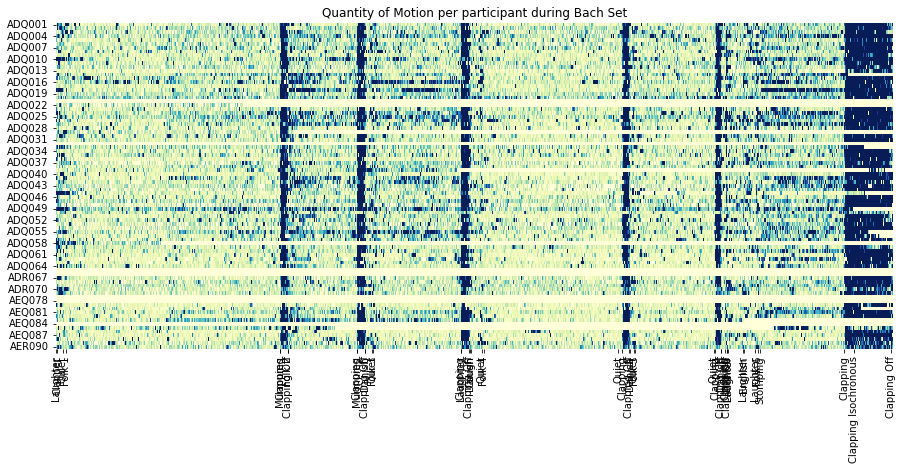

In [86]:

seg_start = concert_times.iloc[134,:].name #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = concert_times.iloc[177,:].name
seg_times = concert_times.iloc[134:177].copy()
print([seg_start,seg_end])

seg_df = aud_df.loc[seg_start:seg_end]
#seg_df = seg_df.loc[:,seg_df.sum()>0]
seg_df = seg_df.fillna(0)

fig, (ax1) = plt.subplots(1, 1,figsize = [15,6])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=0.4,cbar=False, cmap="YlGnBu")

new_xticks = len(seg_df)*(seg_times['Time_s'] - seg_times['Time_s'][0])/(seg_end.timestamp()-seg_start.timestamp())
# plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
ax1.set_xticks(new_xticks)
ax1.set_xticklabels(seg_times['Event'])
plt.title('Quantity of Motion per participant during ' + musics + ' Set')
plt.savefig('./Plots/qom_'+musics+'.png',dpi = 300)
plt.show()

In [87]:
musics = 'Folk'
seg_times = concert_times.iloc[134:177].copy()
seg_times.loc[:,'Time_s'] = seg_times.loc[:,'Time_s'].values - seg_times.iloc[0,0]

#seg_times = concert_times[concert_times['Event'].str.contains('Folk')]
seg_times

,Time_s,Time_ms,Event,Event_Type,Time_Stream,sequence
Datetime,,,,,,
2021-10-26 19:32:14,0.00,6248280,Laughter,Audience Action,7885.52,134
2021-10-26 19:32:18,3.64,6251920,Clapper,Synchronisation,7889.16,135
2021-10-26 19:32:31,16.52,6264800,Quiet,Audience Action,7902.04,136
2021-10-26 19:32:37,23.00,6271280,Folk 1,Music Performance,7908.52,137
2021-10-26 19:40:44,509.52,6757800,Murmures,Audience Action,8395.04,138
2021-10-26 19:40:45,510.68,6758960,Clapping,Audience Action,8396.20,139
2021-10-26 19:41:02,528.02,6776300,Clapping Off,Audience Action,8413.54,140
2021-10-26 19:41:02,528.20,6776480,Folk 2,Music Performance,8413.72,141
2021-10-26 19:43:39,684.60,6932880,Murmures,Audience Action,8570.12,142


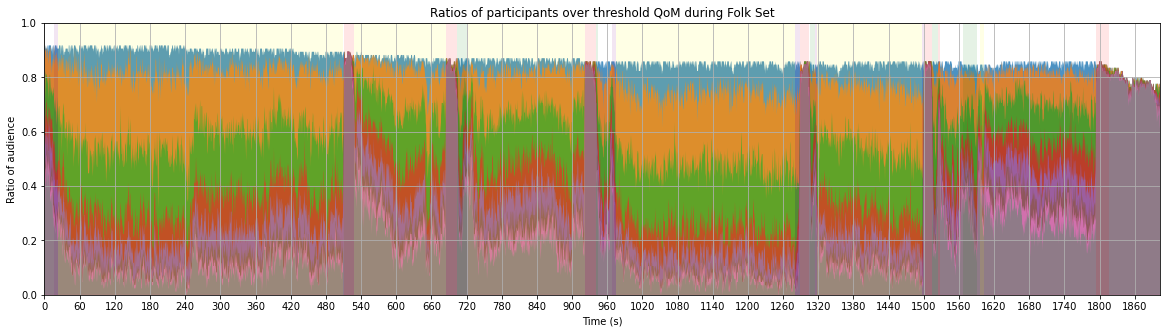

In [88]:
Data = seg_df.copy()
Data.index = np.arange(0,len(seg_df))/10

fig,ax = plt.subplots(1,1,figsize=[20,5] )

thresh = np.arange(0.04,0.32,0.04)
df_threshed = pd.DataFrame()
for th in thresh:
    df = aa.activityCount(Data,1,0.5,th,'UBound')
    df_threshed[str(th)]=df['Total']
    #df.plot(y = 'Total',ax=ax,label=str(th))
    x = df.index
    y1 = 0
    y2 = df.Total
    ax.fill_between(x,y1,y2,alpha = 0.8)


yrange = [0,2.0]
for i in range(len(seg_times)-1):
    r= seg_times.iloc[i,:]
    ei = seg_times.Time_s[i]
    ej = seg_times.Time_s[i+1]
    if r['Event'].endswith('Clapping'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='red', alpha=0.1)
    if r['Event'].startswith(musics):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='yellow', alpha=0.1)
    if r['Event_Type'].endswith('Speech'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='green', alpha=0.1)
    if r['Event'].startswith('Survey'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='blue', alpha=0.1)
    if r['Event'].startswith('Quiet'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='purple', alpha=0.1)

# new_xticks = seg_times['Time_s'] - seg_times['Time_s'][0]
#plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
plt.xticks(np.arange(seg_times.Time_s[0],seg_times.Time_s[-1],60))
plt.xlim([x[0]-1,x[-1]])
plt.ylim([0,1])
plt.ylabel('Ratio of audience')
plt.grid() 
plt.title('Ratios of participants over threshold QoM during ' + musics + ' Set')
plt.xlabel('Time (s)')

plt.savefig('./Plots/ubound__'+musics+'.png',dpi = 300)
plt.show()